# Get data for lsh1 post

The purpose of this notebook is to randomly sample hash collision data for the post *Introduction to Locality-Sensitive Hashes*.

In [2]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np

# TODO Clean up scratch work

## Self-check: What do the visual cues in a box plot typically indicate?

Based a Google one-box answer, it looks like the box itself shows the 1st quartile, median, and 3rd quartile. The outer marks show the minimum and maximum values.

I plan to think in terms of a function $F(d)$ of the distance $d$ between points, with $F(d) = P(x\not\sim y)$ for two random points $x, y$ at distance $d$ from each other. Intuitively, I expect this to be an increasing function going from 0 to 1. Then I can build a box plot at "quartiles" where, for example, $F(d) = 1/4,$ and similarly for 1/2 and 3/4. The min and max values can also be derived from $F()$ by excluding the distances which produce $F(d) \in \{0, 1\}.$

In order to sample $F(d)$ itself, I can choose a fixed set of distances and run many randomized hashes on points at that distance to get an approximate value for $F(d).$ From there, I can assert the monotonicity by setting $\tilde F(d_2) = \max(F(d_1), F(d_2)$ for all consecutive sample distances $d_1 < d_2.$

By the way, the mathematical question of how to take arbitrary samples of $F(d)$ and turn them into a monotone function is interesting to me. It feels like kernel density estimation, except that we want to include the constraint in there somehow. It feels like there ought to be a nice method of doing just that, but I don't have anything just yet.

In [2]:
np.random.normal(size=(2, 2))

array([[-0.38886266,  0.81708542],
       [-0.44917947,  0.01868764]])

In [3]:
def make_hashes(k):
    """ Return a list of k tuples representing random LSH
        hash functions.
    """
    
    # Each hash is given as a (Q, b) tuple.
    # Compute h(x) as floor((Qx+b)[0]).
    hashes = []
    
    for _ in range(k):
        
        # Get a random unitary matrix.
        Q, _ = np.linalg.qr(np.random.normal(size=(2, 2)))
        
        b = np.random.uniform()
        
        hashes.append((Q, b))
    
    return hashes

In [4]:
def count_collisions(hashes, x1, x2):
    """ Calculate all the hash values h_i(x1) and h_i(x2) for each
        hash function h_i() in `hashes`; return the number of times
        these values are equal: #{i: h_i(x1) == h_i(x2)}.
    """
    
    n_collisions = 0
    
    for Q, b in hashes:
        
        h1 = math.floor((Q.dot(x1) + b)[0][0])
        h2 = math.floor((Q.dot(x2) + b)[0][0])
        
        if h1 == h2:
            n_collisions += 1
        
    return n_collisions

In [5]:
def estimate_miss_prob(d, j, k, n_trials=100):
    """ Run a number of hash samples with points at distance d to sample the probability of a miss.
        Use k total hashes, counting at least j collisions as a hit. Run in 2 dimension.
    """
    
    x1 = np.array([[0], [0]])
    x2 = np.array([[d], [0]])
    
    n_hits = 0
    for _ in range(n_trials):
        hashes = make_hashes(k)
        n_collisions = count_collisions(hashes, x1, x2)
        if n_collisions >= j:
            n_hits += 1
    
    return 1.0 - n_hits / n_trials

# scratch

In [8]:
A = np.random.normal(size=(2, 2))
A

array([[-0.38113494,  0.90207681],
       [-0.3785022 , -0.98262152]])

In [23]:
Q, r = np.linalg.qr(A)

In [24]:
Q

array([[-0.7095532 , -0.70465187],
       [-0.70465187,  0.7095532 ]])

In [21]:
x2 = np.array([[0.4], [0]])

In [27]:
Q.dot(x2)[0][0]

-0.2838212809279525

In [30]:
hashes = make_hashes(12)

In [31]:
x1 = np.array([[0], [0]])

In [34]:
count_collisions(hashes, x1, x2)

11

In [55]:
estimate_miss_prob(0.85, 6, 12, n_trials=10000)

0.4971

## Let's plot a cdf for j, k = 6, 12

**Q**: What range of distances do we care about?

In [59]:
[(d, estimate_miss_prob(d, 6, 12)) for d in np.arange(0, 2.5, 0.1)]

[(0.0, 0.0),
 (0.1, 0.0),
 (0.2, 0.0),
 (0.30000000000000004, 0.020000000000000018),
 (0.4, 0.020000000000000018),
 (0.5, 0.050000000000000044),
 (0.6000000000000001, 0.07999999999999996),
 (0.7000000000000001, 0.22999999999999998),
 (0.8, 0.38),
 (0.9, 0.56),
 (1.0, 0.69),
 (1.1, 0.88),
 (1.2000000000000002, 0.92),
 (1.3, 0.95),
 (1.4000000000000001, 0.97),
 (1.5, 0.96),
 (1.6, 0.96),
 (1.7000000000000002, 0.97),
 (1.8, 1.0),
 (1.9000000000000001, 0.98),
 (2.0, 1.0),
 (2.1, 1.0),
 (2.2, 0.99),
 (2.3000000000000003, 1.0),
 (2.4000000000000004, 1.0)]

**A**: Looks like a good range here is 0.2 to 2.0.

In [66]:
%%time
x = np.arange(0.2, 2.0, 0.02)
cdf = [estimate_miss_prob(d, 6, 12, n_trials=200) for d in x]

CPU times: user 12.1 s, sys: 53.8 ms, total: 12.1 s
Wall time: 12.2 s


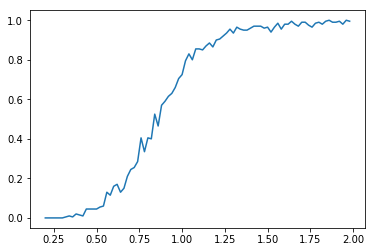

In [67]:
plt.plot(x, cdf)
plt.show()

In [68]:
%%time
x = np.arange(0.2, 2.0, 0.02)
cdf = [estimate_miss_prob(d, 6, 12, n_trials=400) for d in x]

CPU times: user 23.9 s, sys: 119 ms, total: 24 s
Wall time: 24.2 s


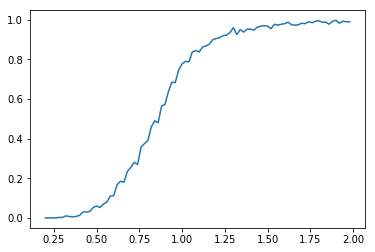

In [69]:
plt.plot(x, cdf)
plt.show()

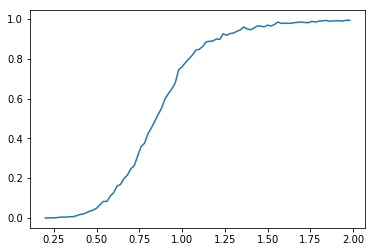

In [76]:
x = np.arange(0.2, 2.0, 0.02)
cdf = [estimate_miss_prob(d, 6, 12, n_trials=2000) for d in x]
plt.plot(x, cdf)
plt.show()

### Try to find the quartiles

In [26]:
def estimate_percentile(p, j, k, n_trials=400):
    """ Return the estimated distance d at which miss_prob(d, j, k) = p.
        Use n_trials sample points per internal call to
        estimate_miss_prob().
    """
    
    lo, hi = 0, 50.0  # These values ought to handle all currently relevant cases.
    
    while (hi - lo) > 0.01:
        
        mid = (lo + hi) / 2
        
        # print('mid = %f' % mid)
        
        p_est = estimate_miss_prob(mid, j, k, n_trials)
        
        # print('  p_est = %.2f' % p_est)
        
        if p_est < p:
            lo = mid
        else:
            hi = mid
    
    return (hi + lo) / 2

In [75]:
p_estimates = []

for p in [0.00001, 0.25, 0.5, 0.75, 0.999999]:
    
    p_est = estimate_percentile(p, 6, 12) 
    
    p_estimates.append(p_est)
    
    print(p_est)

0.2294921875
0.6982421875
0.8349609375
0.9912109375
2.2216796875


In [7]:
%%time
# Re-run of the last cell, since I'm getting back into
# understanding this code after a break.

p_estimates = []

for p in [0.00001, 0.25, 0.5, 0.75, 0.999999]:
    
    p_est = estimate_percentile(p, 6, 12) 
    
    p_estimates.append(p_est)
    
    print(p_est)

0.3173828125
0.6982421875
0.8642578125
1.0009765625
2.9931640625
CPU times: user 14.8 s, sys: 234 ms, total: 15 s
Wall time: 15.7 s


In [32]:
def get_box_coords(j, k, n_trials=400):
    """ Return a 1d numpy array with the boxplot values for the given j, k values. """
    p_estimates = []
    for p in [0.00001, 0.25, 0.5, 0.75, 0.999999]:
        p_est = estimate_percentile(p, j, k, n_trials) 
        p_estimates.append(p_est)
    return np.array(p_estimates)

In [33]:
%%time
boxplot_values = []
for j in range(3, 13):
    print('Working on j=%d' % j)
    boxplot_values.append(get_box_coords(j, 12, n_trials=800))

bp_values_normed = boxplot_values[:]
for bp_vals in bp_values_normed:
    bp_vals /= bp_vals[2]

Working on j=3
Working on j=4
Working on j=5
Working on j=6
Working on j=7
Working on j=8
Working on j=9
Working on j=10
Working on j=11
Working on j=12
CPU times: user 6min 8s, sys: 2.97 s, total: 6min 11s
Wall time: 6min 21s


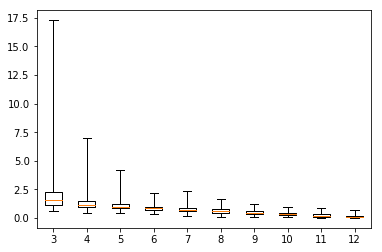

In [28]:
plt.boxplot(boxplot_values, whis=100.0, positions=range(3, 13))
plt.show()

### Note

This next set of box plots was generated with `n_trials` set to 400.

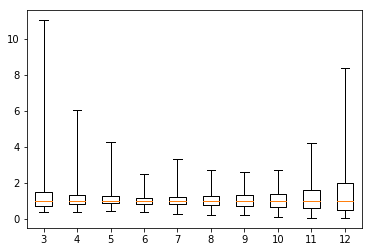

In [31]:
# Next, let's create a normalized plot where the minimum for each j
# is always scaled to 1.0. (Or should it be the median?)

bp_values_normed = boxplot_values[:]
for bp_vals in bp_values_normed:
    bp_vals /= bp_vals[2]
    
plt.boxplot(bp_values_normed, whis=100.0, positions=range(3, 13))
plt.show()

Wow, that actually looks very cool. I think I'll re-run
the data because I suspect that we're seeing a bit of noise here.

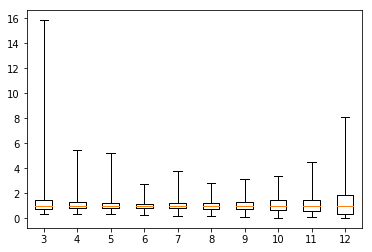

In [35]:
# This plot is being generated with n_trails = 800.

plt.boxplot(bp_values_normed, whis=100.0, positions=range(3, 13))
plt.show()

### Note

I think we're going to need to user more data points to get more reliable numbers here.

Also, I suspect we could be being more efficient in how we're collecting the data.

Based on the cdf plots above, it looks like 2000 is a decent number of trials, although even that one was a tad shaky.
Maybe I ought to go for something like 4000. Could take a long time, though.

In [36]:
%%time
boxplot_values = []
for j in range(3, 13):
    print('Working on j=%d' % j)
    boxplot_values.append(get_box_coords(j, 12, n_trials=4000))

bp_values_normed = boxplot_values[:]
for bp_vals in bp_values_normed:
    bp_vals /= bp_vals[2]

Working on j=3
Working on j=4
Working on j=5
Working on j=6
Working on j=7
Working on j=8
Working on j=9
Working on j=10
Working on j=11
Working on j=12
CPU times: user 30min 6s, sys: 11.3 s, total: 30min 17s
Wall time: 53min 25s


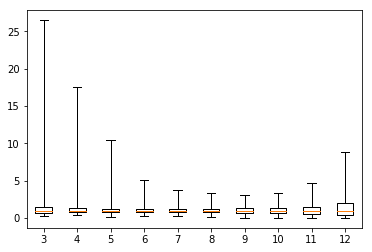

In [37]:
# This plot is being generated with n_trails = 800.

plt.boxplot(bp_values_normed, whis=100.0, positions=range(3, 13))
plt.show()

In [38]:
boxplot_values

[array([ 0.28094303,  0.73280943,  1.        ,  1.43222004, 26.50491159]),
 array([ 0.34203655,  0.82767624,  1.        ,  1.31331593, 17.59007833]),
 array([ 0.19626168,  0.85046729,  1.        ,  1.21183801, 10.39563863]),
 array([0.26545455, 0.82545455, 1.        , 1.18181818, 5.08      ]),
 array([0.20502092, 0.78242678, 1.        , 1.18410042, 3.80334728]),
 array([0.12820513, 0.76410256, 1.        , 1.25641026, 3.28717949]),
 array([0.05806452, 0.72903226, 1.        , 1.29677419, 3.0516129 ]),
 array([0.04504505, 0.67567568, 1.        , 1.3963964 , 3.32432432]),
 array([0.01408451, 0.6056338 , 1.        , 1.53521127, 4.74647887]),
 array([0.03448276, 0.44827586, 1.        , 1.96551724, 8.79310345])]

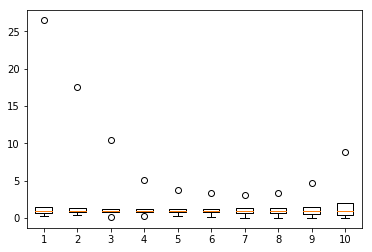

In [43]:
bp_values = np.array(boxplot_values)
plt.boxplot(bp_values.T)
plt.show()

In [45]:
np.save('boxplot_values.npy', bp_values)

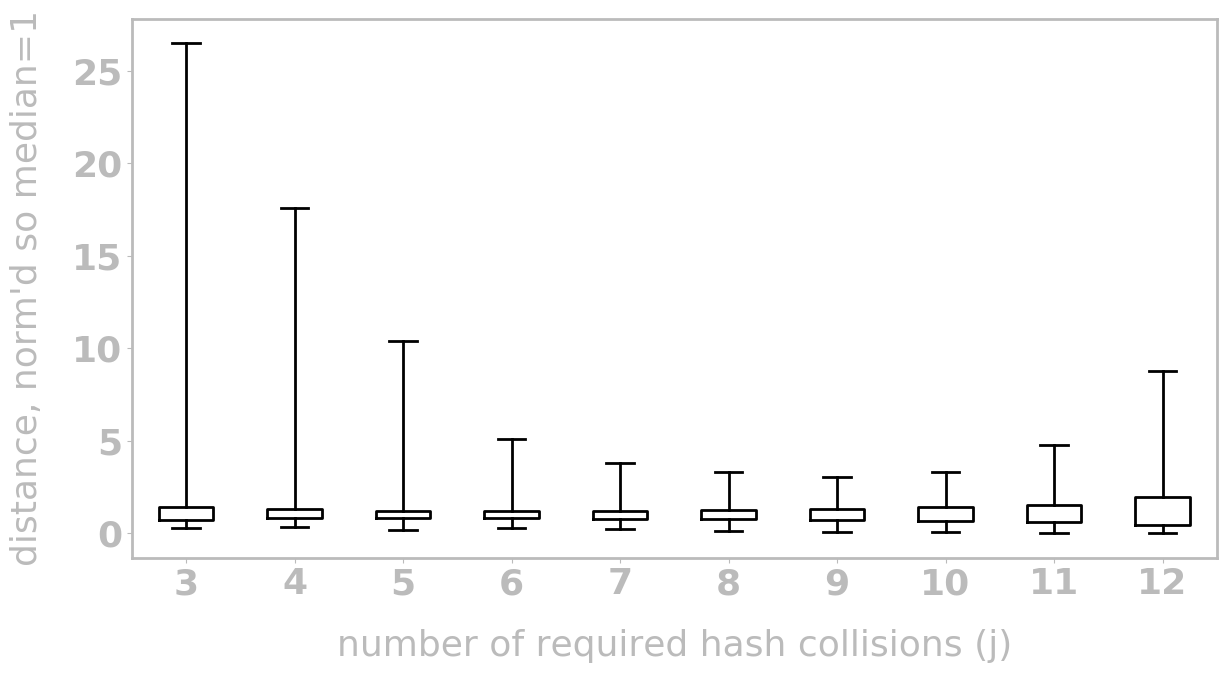

In [119]:
font = {'weight' : 'bold',
        'size'   : 26}

plt.rcdefaults()
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(14, 7))

line_width = 2
light_color = '#' + 'b' * 6

for sp_key, sp in ax.spines.items():
    sp.set_color(light_color)
    sp.set_linewidth(line_width)
ax.tick_params(axis='x', colors=light_color)
ax.tick_params(axis='y', colors=light_color)

ax.set_xlabel('number of required hash collisions (j)')
ax.set_ylabel('distance, norm\'d so median=1')
ax.yaxis.label.set_color(light_color)
ax.xaxis.label.set_color(light_color)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

if False:
    bp = plt.boxplot(bp_values_normed, whis=100.0, positions=range(3, 13), zorder=100)

    # Adjust all line widths in the box plot.
    for key, lines in bp.items():
        for line in lines:
            line.set_linewidth(line_width)

bp = plt.boxplot(bp_values_normed, whis=100.0, positions=range(3, 13), zorder=200)

# Adjust all line widths in the box plot.
for key, lines in bp.items():
    for line in lines:
        line.set_linewidth(line_width)

for line in bp['medians']:
    line.set_color((0, 0, 1, 0))
    
plt.show()

In [61]:
type(a['medians'])

list

In [64]:
dir(a['medians'][0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_dashOffset',
 '_dashSeq',
 '_dashcapstyle',
 '_dashjoinstyle',
 '_drawStyles_l',
 '_drawStyles_s',
 '_drawstyle',
 '_get_markerfacecolor',
 '_get_rgba_face',
 '_get_rgba_ln_color',
 '_get_transformed_path',
 '_gid',
 '_invalidx',
 '_invalidy',
 '_is_sorted',
 '_label',
 '_lineStyles',
 '_linestyle',
 '_linestyles',
 '_linewidth',
 '_marker',
 '_markeredgecolor',
 '_markeredgewidth',
 '_markerfacecolor',
 '_markerfacecoloralt',
 '_markersize',
 '_markevery',
 '_mouseover',
 '_oid',
 '_pa

### Quick run of plt.boxplot

NEXT: Draw two or more identical box plots to gain understanding of how to do that.

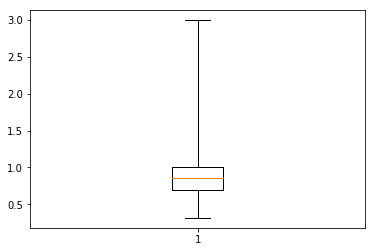

In [17]:
plt.boxplot(p_estimates, whis=100.0)
plt.show()

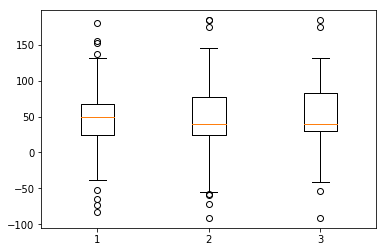

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)


# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low), 0)
data.shape = (-1, 1)
d2.shape = (-1, 1)
# data = concatenate( (data, d2), 1 )
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2, 0]]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)

plt.show()

In [10]:
type(data), len(data)

(list, 3)

In [12]:
[d.shape for d in data]

[(95, 1), (95, 1), (48,)]

In [13]:
plt.boxplot?

Signature: plt.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_xticks=True, autorange=False, zorder=None, hold=None, data=None)
Docstring:
Make a box and whisker plot.

Make a box and whisker plot for each column of ``x`` or each
vector in sequence ``x``.  The box extends from the lower to
upper quartile values of the data, with a line at the median.
The whiskers extend from the box to show the range of the
data.  Flier points are those past the end of the whiskers.

Parameters
----------
x : Array or a sequence of vectors.
    The input data.

notch : bool, optional (False)
    If `True`, will produce a notched box plot. Otherwise, a
    rectangular boxplot is produced. The notches r

In [84]:
a

['get_data.ipynb', 'lsh-env']

In [85]:
time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 22.9 µs
